# Basic gimVI tutorial
## Impute missing genes in Spatial Data from Sequencing Data

In [1]:
import sys

sys.path.append("../../")
sys.path.append("../")

In [2]:
def allow_notebook_for_test():
    print("Testing the gimvi notebook")


test_mode = False
save_path = "data/"


def if_not_test_else(x, y):
    if not test_mode:
        return x
    else:
        return y


if not test_mode:
    save_path = "../../data"

In [3]:
from scvi.dataset import (
    PreFrontalCortexStarmapDataset,
    FrontalCortexDropseqDataset,
    SmfishDataset,
    CortexDataset,
)
from scvi.models import JVAE, Classifier
from scvi.inference import JVAETrainer

import notebooks.utils.gimvi_tutorial as gimvi_utils

INFO:hyperopt.utils:Failed to load dill, try installing dill via "pip install dill" for enhanced pickling support.
INFO:hyperopt.fmin:Failed to load dill, try installing dill via "pip install dill" for enhanced pickling support.
INFO:hyperopt.mongoexp:Failed to load dill, try installing dill via "pip install dill" for enhanced pickling support.


In [4]:
import numpy as np
import copy

## Load two datasets: one with spatial data, one from sequencing

Here we load: 
- **Cortex**: a scRNA-seq dataset of 3,005 mouse somatosensory cortex cells (Zeisel et al., 2015)
- **osmFISH**: a smFISH dataset of 4,462 cells and 33 genes from the same tissue (Codeluppi et al., 2018)

In [5]:
data_spatial = SmfishDataset(save_path=save_path)
data_seq = CortexDataset(
    save_path=save_path, genes_to_keep=data_spatial.gene_names, total_genes=None
)
if test_mode:
    data_seq = data_spatial

INFO:scvi.dataset.dataset:File ../../data/osmFISH_SScortex_mouse_all_cell.loom already downloaded
INFO:scvi.dataset.smfish:Loading smFISH dataset
../../scvi/dataset/dataset.py:1276: RuntimeWarning: divide by zero encountered in log
  log_counts = np.log(data.sum(axis=1))
/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
INFO:scvi.dataset.dataset:Computing the library size for the new data
INFO:scvi.dataset.dataset:Downsampled from 6471 to 4530 cells
INFO:scvi.dataset.dataset:Remapping labels to [0,N]
INFO:scvi.dataset.dataset:Remapping batch_indices to [0,N]
INFO:scvi.dataset.dataset:File ../../data/expression.bin already downloaded
INFO:scvi.dataset.cortex:Loading Cortex data
INFO:scvi.dataset.cortex:Finished preprocessing Cortex data
INFO:scvi.dataset.dataset:Remapping labels to [0,N]
INFO:scvi.dataset.dataset:Remapping batch_indices to [0,N]


- **FrontalCortexDropseq**: a scRNA-seq dataset of 71,639 mouse frontal cortex cells (Saunders et al., 2018)
- **PreFrontalCortexStarmap**: a starMAP dataset of 3,704 cells and 166 genes from the mouse pre-frontal cortex (Wang et al., 2018)


In [6]:
# data_spatial = PreFrontalCortexStarmapDataset(save_path=save_path)
# data_seq = FrontalCortexDropseqDataset(
#     save_path=save_path, genes_to_keep=data_spatial.gene_names
# )
# data_seq.subsample_cells(5000)

**Hide some genes in the osFISH dataset to score the imputation**

In [7]:
data_seq.filter_cells_by_count(1)
data_spatial.filter_cells_by_count(1)

INFO:scvi.dataset.dataset:Computing the library size for the new data
INFO:scvi.dataset.dataset:Downsampled from 3005 to 2996 cells
INFO:scvi.dataset.dataset:Computing the library size for the new data
INFO:scvi.dataset.dataset:Downsampled from 4530 to 4530 cells


In [8]:
train_size = 0.8

gene_names_rnaseq = data_seq.gene_names
np.random.seed(0)
n_genes = len(gene_names_rnaseq)
gene_ids_train = sorted(
    np.random.choice(range(n_genes), int(n_genes * train_size), False)
)
gene_ids_test = sorted(set(range(n_genes)) - set(gene_ids_train))

gene_names_fish = gene_names_rnaseq[gene_ids_train]

# Create copy of the fish dataset with hidden genes
data_spatial_partial = copy.deepcopy(data_spatial)
data_spatial_partial.filter_genes_by_attribute(gene_names_fish)
data_spatial_partial.batch_indices += data_seq.n_batches

INFO:scvi.dataset.dataset:Downsampling from 33 to 26 genes
INFO:scvi.dataset.dataset:Computing the library size for the new data
INFO:scvi.dataset.dataset:Filtering non-expressing cells.
INFO:scvi.dataset.dataset:Computing the library size for the new data
INFO:scvi.dataset.dataset:Downsampled from 4530 to 4530 cells


**Configure the Joint Model**
The joint model can take multiple datasets with potentially different observed genes. 
All dataset will be encoded and decoded with the union of all genes.
It requires:
- The gene mappings from each dataset to the common decoded vector:
    * *Eg: dataset1 has genes ['a', 'b'] and dataset2 has genes ['b', 'c'], then a possible output can be ['b', 'a', 'c'] such that the mappings are [1, 0] and [0, 2]*
    * *Usually, if the genes of dataset2 are included in dataset1, it is way more efficient to keep the order of dataset1 in the output and use `slice(None)` as a mapping for dataset1*
    
- The number of inputs (ie) number of genes in each dataset
- The distributions to use for the generative process: usually scRNA-seq is modelled with ZINB (because of technical dropout) and FISH with NB or even Poisson
- Whether to model the library size with a latent variable or use the observed value

In [9]:
datasets = [data_seq, data_spatial_partial]
generative_distributions = ["zinb", "nb"]
gene_mappings = [slice(None), np.array(gene_ids_train)]
n_inputs = [d.nb_genes for d in datasets]
total_genes = data_seq.nb_genes
n_batches = sum([d.n_batches for d in datasets])

model_library_size = [True, False]

n_latent = 8
kappa = 1

In [10]:
import torch

torch.manual_seed(0)

model = JVAE(
    n_inputs,
    total_genes,
    gene_mappings,
    generative_distributions,
    model_library_size,
    n_layers_decoder_individual=0,
    n_layers_decoder_shared=0,
    n_layers_encoder_individual=1,
    n_layers_encoder_shared=1,
    dim_hidden_encoder=64,
    dim_hidden_decoder_shared=64,
    dropout_rate_encoder=0.2,
    dropout_rate_decoder=0.2,
    n_batch=n_batches,
    n_latent=n_latent,
)

discriminator = Classifier(n_latent, 32, 2, 3, logits=True)

trainer = JVAETrainer(model, discriminator, datasets, 0.95, frequency=1, kappa=kappa)

In [11]:
n_epochs = if_not_test_else(200, 1)
trainer.train(n_epochs=n_epochs)

training: 100%|██████████| 200/200 [04:24<00:00,  1.27s/it]


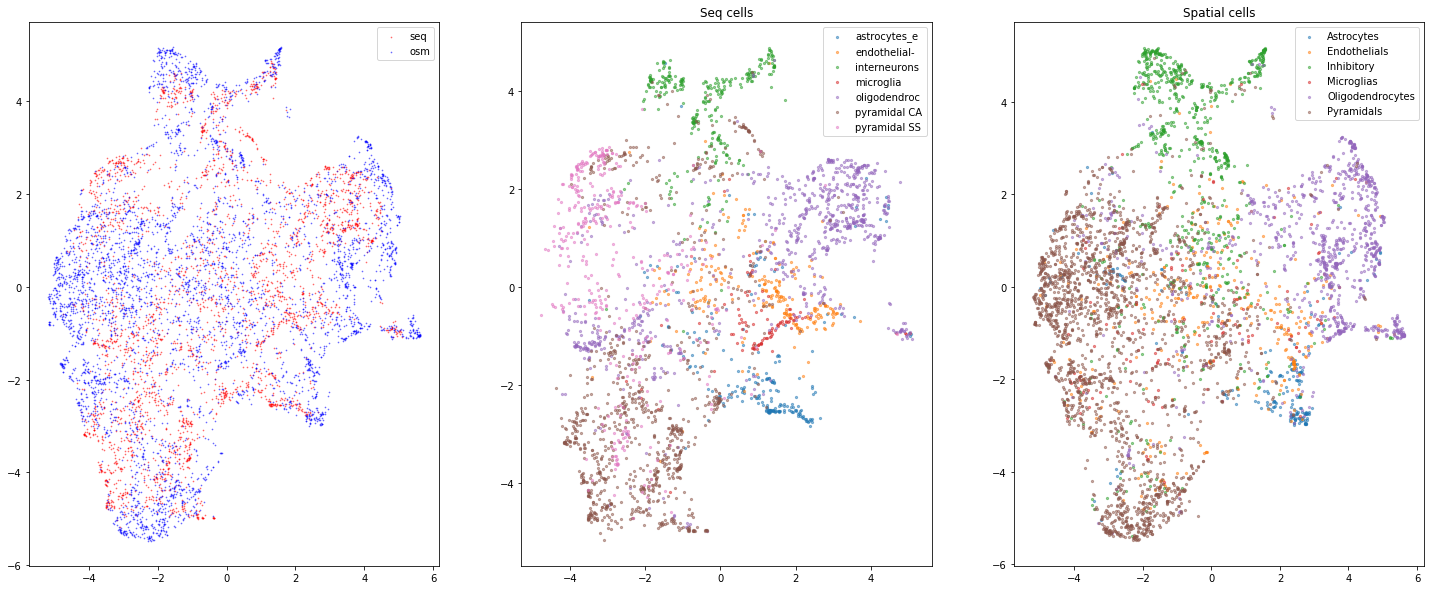

In [12]:
gimvi_utils.plot_umap(trainer)

In [13]:
gimvi_utils.imputation_score(trainer, data_spatial, gene_ids_test, True)

0.25089044336342275

### Plot imputation for *LAMP5*, hidden in the training

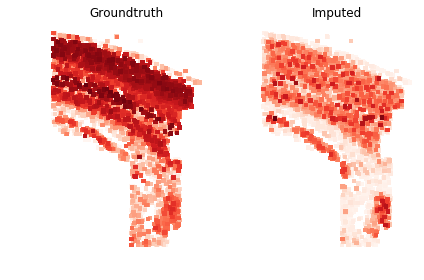

In [14]:
gimvi_utils.plot_gene_spatial(trainer, data_spatial, 9)

### Inspect classification accuracy (we expect a uniform matrix)
If the matrix is diagonal, the `kappa` needs to be scaled up to ensure mixing.

In [15]:
discriminator_classification = trainer.get_discriminator_confusion()
discriminator_classification

array([[0.5616336 , 0.43836704],
       [0.41276518, 0.58723474]], dtype=float32)

In [16]:
import pandas as pd

results = pd.DataFrame(
    trainer.get_loss_magnitude(),
    index=["reconstruction", "kl_divergence", "discriminator"],
    columns=["Sequencing", "Spatial"],
)
results.columns.name = "Dataset"
results.index.name = "Loss"
results

Dataset,Sequencing,Spatial
Loss,,
reconstruction,868.178913,1765.545235
kl_divergence,201.512057,206.783453
discriminator,24.937387,20.623563
